출처 : https://unfinishedgod.netlify.app/2021/04/21/python-%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90-%EC%A3%BC%EA%B0%80-%EC%98%88%EC%B8%A1/

# 삼성전자 주가 예측 

## Step 0 데이터 수집 : Yahoo Finance 데이터 불러오기

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import yfinance as yf
from matplotlib import font_manager, rc
# mpl.rcParams['axes.unicode_minus'] = False
f_path = "c:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=f_path).get_name()
rc('font', family=font_name)

In [2]:
df = yf.download("005930.KS",start = '2020-01-01',end = '2021-04-21',progress=False)
df = df[['Close']]
df = df.reset_index()
df.columns = ['day','price']
df['day'] = pd.to_datetime(df['day'])
df.set_index('day',inplace=True)
df.head()

,price
day,
2020-01-02,55200.0
2020-01-03,55500.0
2020-01-06,55500.0
2020-01-07,55800.0
2020-01-08,56800.0


## Step1 탐색: 시간 정보가 포함된 데이터 살펴보기

- 우선 삼성전자 주가 데이터를 탐색해보도록 하겠습니다. 
- 마지막 날짜 5일을 Test-set으로 지정하도록 하겠습니다.

In [3]:
train = df[:-5]
print(df.shape,train.shape)
test = df[-5:]
print(df.shape,test.shape)

(322, 1) (317, 1)
(322, 1) (5, 1)


### 시각화

In [4]:
def plot_samsung(df):
    fig,ax = plt.subplots(figsize=[15,8])
    df.plot(ax=ax)
    
    # 4만 최저점 
    ax.annotate('',xy=('2020-03-23',42500.0),xytext = ('2020-02-01',48300),
               arrowprops= dict(arrowstyle="->",connectionstyle='arc3,rad=0.2'))
    plt.text("2020-01-01",48300,'최저점 \n-날짜: 2020-03-23 \n-종가 :42,500',fontsize=13)
    # 5만
    ax.annotate('',xy=('2020-04-17',51400.0),xytext=("2020-03-31",55500),
               arrowprops= dict(arrowstyle="->",connectionstyle='arc3,rad=0.2'))
    plt.text("2020-03-17",56400,'5만 회복 \n-날짜: 2020-04-17\n-종가: 51,400',fontsize=13)
    # 6만
    ax.annotate('', xy=('2020-09-14' ,60400.0), xytext=('2020-07-01', 66400),
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3,rad=0.2"),
               )

    plt.text('2020-06-05',66900, "6만 회복 \n-날짜: 2020-09-14\n-종가: 60,400",fontsize=13)

    # 7만
    ax.annotate('', xy=('2020-12-04' ,71500.0), xytext=('2020-09-15', 75000),
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3,rad=0"),
               )

    plt.text('2020-08-15',76000, "7만... 어??? \n-날짜: 2020-10-04\n-종가: 71,500",fontsize=15)

    # 8만
    ax.annotate('', xy=('2020-12-30' ,81000.0), xytext=('2020-11-15', 85000),
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3,rad=0"),
               )

    plt.text('2020-10-15',85000, "8만전자..!! \n-날짜: 2020-10-30\n-종가: 81,000",fontsize=16)

    # 9만
    ax.annotate('', xy=('2021-01-11' ,91000.0), xytext=('2021-02-11', 70000),
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3,rad=0"),
               )

    plt.text('2021-01-20',58000, "가즈아!!!!!!! \n!!!!!!!!!!!!! \n-날짜: 2021-02-11\n-종가: 91,000",fontsize=20)
    
    # Scatter plot 추가 
    y1 = ['2020-03-23','2020-04-17','2020-09-14','2020-12-04','2020-12-30','2021-01-11']
    y2 = [42500,51400,60400,71500,81000,91000]
    plt.scatter(y1,y2,s=50,color='r')
    plt.title("삼성전자 주가")
    plt.show()

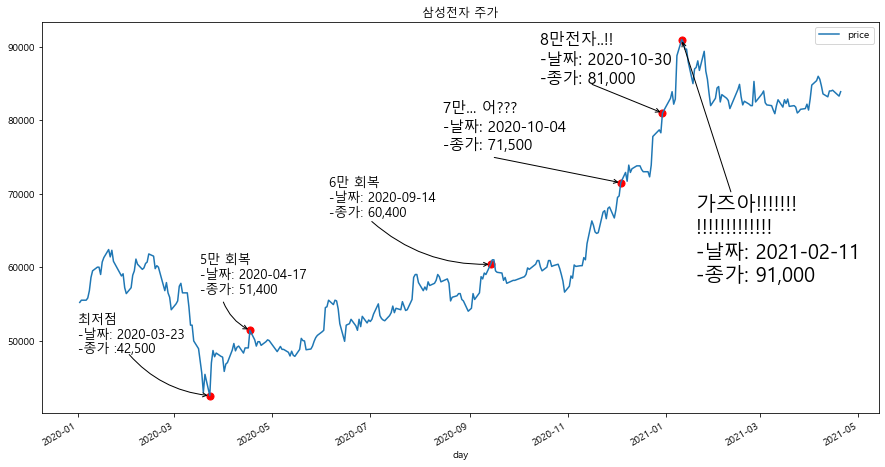

In [5]:
plot_samsung(df)

## Step2 예측: 파이썬 라이브러리를 활용한 시세 예측

### Model 1: ARIMA

- ARIMA 기법은 전통적인 시계열 예측 방법으로 크게 2가지 개념을 포함하고 있습니다. 
- AR(Autoregression) 모델로 자기 자신의 과거를 정보로 사용하는 개념이다. 이는 "현재의 상태는 이전의 상태를 참고해서 계산된다"라는 아이디어를 기본 전제로 한다. 
- MA(Moving Average)모델로 "이번 항에서의 오차를 이용하여 현재 항의 상태를 추론하자"라는 방법입니다. 
- 위의 두 모델을 합친 것을 ARMA 모델이라고 하며 여기에 추세 변동의 경향성까지 반영한 방법이 ARIMA 모델입니다. 

파이썬에서는 STATSMODEL 모듈로 ARIMA 분석을 수행할 수 있습니다. ARIMA 클래스에 order = (2,1,2) 라고 입력되어진 파라미터는 AR이 몇 번째 과거까지를 바라보는지에 대한 파라미터, 차분에 대한 파라미터 (1), MA가 몇 번째 과거까지를 바라보는지에 대한 파라미터 (2)를 의미하게 됩니다. 

`차분` : 현재 상태의 변수에서 바로 전 상태의변수를 빼주는 것을 의미하며, 시계열 데이터의 불규칙성을 조금이나마 보정해주는 역할을 한다. 또한, 앞서 말한 ARIMA 모델의 경향성을 의미합니다. 

이제 아래의 실행 결과를 분석해보자. 실행 결과의 표를 살펴보면 상수항을 제외한 모든 계수의 p-value( P>|z| )가 0.05이하로 유의미한 것으로 나타난다. 이것은 AR과 MA모두 2로 설정하는 것이 꽤나 의미 있는 분석 결과를 도출한다는 것을 말한다.

In [6]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm 
import warnings;warnings.filterwarnings('ignore')

# (AR=2,차분=1,MA=2) 파라미터로 ARIMA 모델 학습
model = ARIMA(train.price.values,order= (2,1,2))
model_fit = model.fit(trend='c',full_output=True,disp=True)

In [7]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  316
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2693.879
Method:                       css-mle   S.D. of innovations           1212.701
Date:                Thu, 22 Apr 2021   AIC                           5399.758
Time:                        21:23:13   BIC                           5422.293
Sample:                             1   HQIC                          5408.761
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         91.4546     68.804      1.329      0.184     -43.398     226.307
ar.L1.D.y     -1.6290      0.017    -94.431      0.000      -1.663      -1.595
ar.L2.D.y     -0.9743      0.016    -60.958      0.000      -1.006      -0.943
ma.L1.D.y      1.6342      0.017     98.172      0.000       1.602       1.667
ma.L2.D.y      1.0000      0.019     51.939      0.000       0.962       1.038
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.8360           -0.5723j            1.0131           -0.4045
AR.2           -0.8360           +0.5723j            1.0131            0.4045
MA.1           -0.8171           -0.5765j            1.0000           -0.4022
MA.2           -0.8171           +0.5765j            1.0000            0.4022
-----------------------------------------------------------------------------
"""

rule of thumb 
- 보통은 p와 q의 합이 2 미만인 경우, 혹은 p와 q의 곱이 0을 포함한 짝수인 경우가 좋은 파라미터의 조합이라고 알려져 있다. 

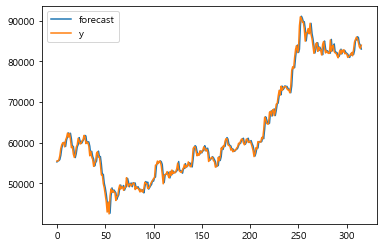

In [8]:
# 학습 데이터에 대한 예측 결과
fig = model_fit.plot_predict()

<AxesSubplot:title={'center':'실제값과 예측값의 잔차'}>

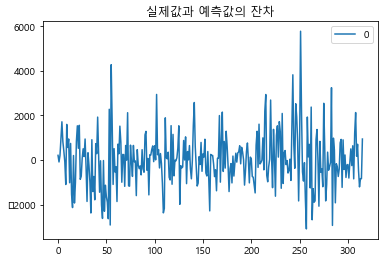

In [9]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title="실제값과 예측값의 잔차")

이번에는 ARIMA 모델을 평가해보도록 하겠습니다. 테스트 전용 데이터가 필요한데, 이번에는 5일 동안의 미래를 테스트 데이터로 사용해보겠습니다. 불규칙적 시계열 예측의 경우에는 먼 미래를 예측하는 것의 큰 의미가 없기 때문에 '앞으로 N일동안 어느정도로 상승/하락할 것이다'정도의 대략적인 경향 예측만을 수행하는 것이 일반적이기 때문이다. 

모델의 평가 과정은 다음과 같다. 
- model_fit.forecast(steps=5) 로 향후 5일의 가격을 예측하는 pred_y로 정의한다. 
- 마지막 5일을 test_y로 정의한다. 
- 모델 예측의 상한 하한을 upper lower로 정의한다. 
- 정의한 모든 값을 비교하며 5일 동안의 상승 경향 예측이 얼마나 맞는지 평가한다.

In [10]:
forecast = model_fit.forecast(steps=5)

pred = forecast[0].tolist()

# 실제 5일의 데이터 
test_y = test.price.values

# 마지막 5일 예측의 최솟값,최댓값 
pred_lower=[]; pred_upper=[]

for low,up in forecast[2]:
    pred_lower.append(low)
    pred_upper.append(up)

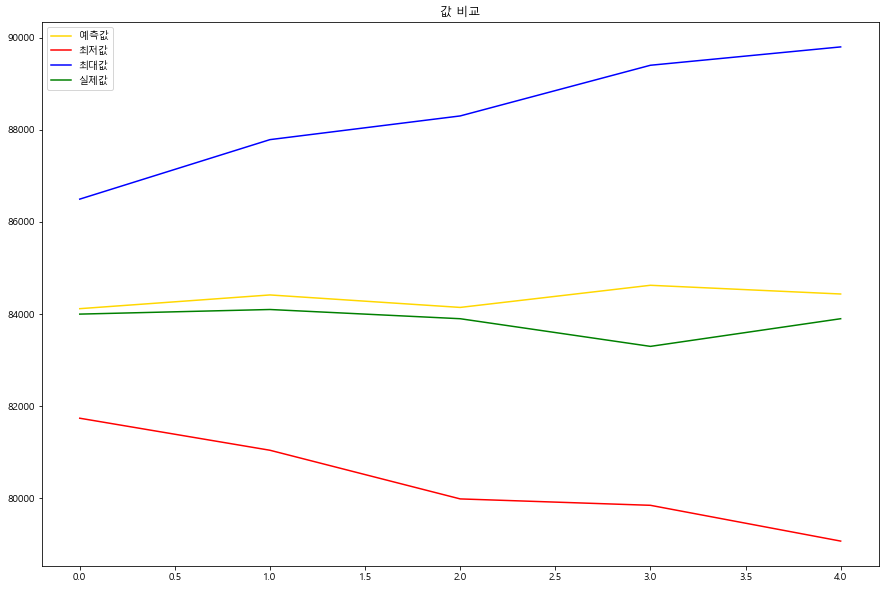

In [11]:
plt.figure(figsize=[15,10])
# 모델이 예측한 가격 그래프 
plt.plot(pred,color='gold')

# 모델이 예측한 최저 가격 그래프
plt.plot(pred_lower,color='red')

# 모델이 예측한 최고 가격 그래프
plt.plot(pred_upper,color='blue')

plt.plot(test_y,color='green')

plt.legend(['예측값','최저값','최대값','실제값'])
plt.title('값 비교')
plt.show()

### Model 3: Facebook Prophet

Facebook Prophet 
- ARIMA보다 조금 더 정확한 트렌드 예측 분석을 제공 
- Additive 모델이라는 모델링 방법에 기반한 시계열 예측 모델 
- 시계열 데이터의 트렌드성 (연간/월간/일간)을 예측하는 것에 초점이 맞추어져 있다. 

Additve 모델 
- 선형회귀 분석의 단점을 극복하기 위해 개량된 분석 방법의 하나 
- 극복을 위해 각 피쳐마다 비선형적인 적합을 가능하게 하는 일련의 방법을 적용 
https://peerj.com/preprints/3190/

fbprophet 라이브러리를 사용하기 위해서는 데이터 프레임의 피처를 'ds'와 'y'로 변경해야 한다. Prophet이라는 클래스를 선언한 뒤, fit() 함수로 모델을 학습시켜준다. 

- seasonality_mode : 연간, 월간, 주간, 일간 등의 트렌드 성을 반영하는 것을 의미하는 파라미터 
- changepoint_prior_scale: 트렌드가 변경되는 문맥을 반영하는 파라미터, 수치가 높을수록 모델은 과적합에 가까워 진다. 

In [12]:
from fbprophet import Prophet

df.reset_index(inplace=True)
df.columns =['ds','y']
train = df[:-5]
test = df[-5:]

# 모델 적용
prophet = Prophet(seasonality_mode = 'multiplicative',yearly_seasonality=True,
                 weekly_seasonality=True,daily_seasonality=True,
                 changepoint_prior_scale=0.5)

prophet.fit(train)

make_future_dataframe(periods=5,freq='d'), prophet.predict(future_data)를 실행하면 학습 데이터 셋 기반의 5일 단위 예측 데이터를 얻을 수 있습니다.

In [13]:
future = prophet.make_future_dataframe(periods=5,freq='d')
forecast_data = prophet.predict(future)
forecast_data[['ds','yhat','yhat_lower','yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-02,54234.596663,52562.472760,55924.991565
1,2020-01-03,54773.920668,53213.655065,56406.765442
2,2020-01-06,56535.314212,54902.319124,58226.559338
3,2020-01-07,57254.709520,55530.638870,58715.141563
4,2020-01-08,57789.340049,56251.222966,59336.833326
...,...,...,...,...
317,2021-04-14,84739.490295,83172.153512,86322.050267
318,2021-04-15,84473.668357,82824.240999,86216.270351
319,2021-04-16,84159.711643,82330.352709,85841.110030
320,2021-04-17,75077.671354,73475.292379,76633.360087


fbprophet 모델의 학습 결과를 시각화한 결과는 아래와 같습니다. 그래프의 검은 점은 실제 가격을 나타낸 것이고, 파란 선은 예측 가격을 나타낸 것입니다. 이 모델 역시 ARIMA 모델과 마찬가지로 학습 데이터셋에 대해서는 거의 정확한 예측을 하고 있습니다. 하지만 시계열 데이터 분석에서 학습 데이터를 잘 예측하는 건 큰 의미가 없습니다.

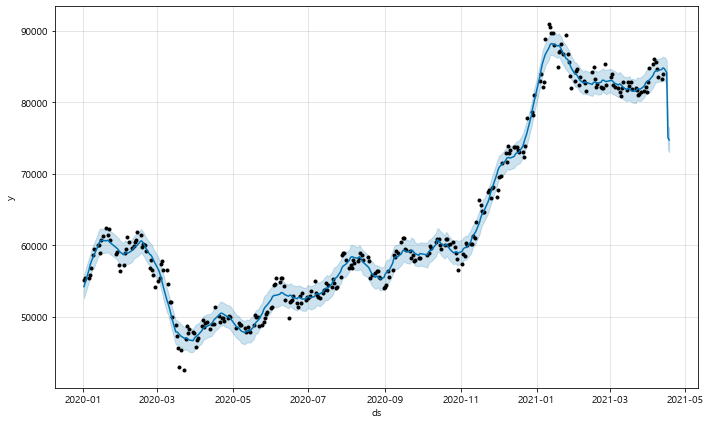

In [15]:
fig1 = prophet.plot(forecast_data)

그리고 다음 그래프는 fbprophet에서 제공하는 트렌드 정보 시각화 그래프 입니다. 앞서 seasonality_mode 파라미터를 설정해 놓은 경우에만 이 시각화가 가능합니다. 

이를 통해 시계열 데이터가 어떤 흐름을 가지고 변화하는지를 살펴볼 수 있습니다. 전체적인 데이터의 트렌드는 아래의 첫 번째 그래프로 살펴볼 수 있고 이어지는 그래프에서는 year,weekly,daily 순의 트렌드를 확인할 수 있습니다.

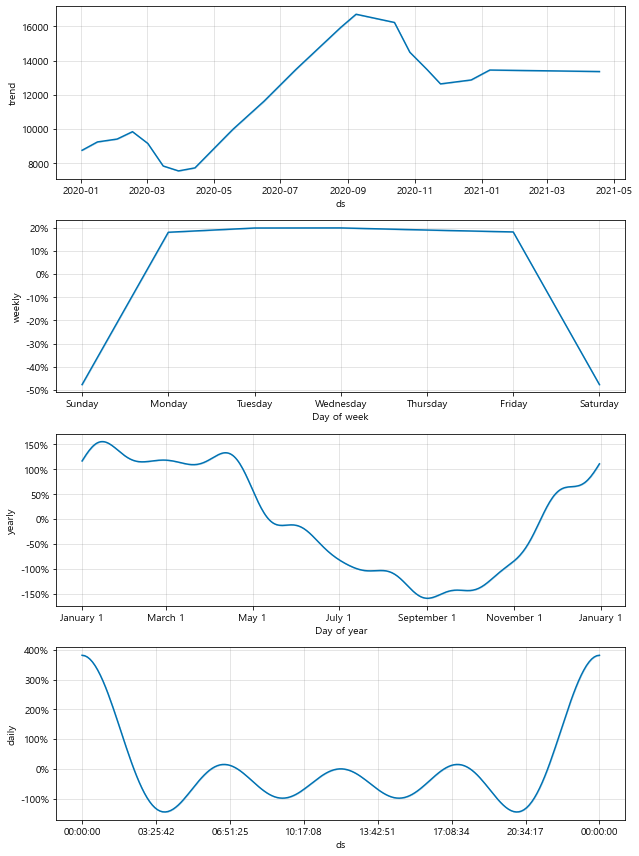

In [16]:
fig2 = prophet.plot_components(forecast_data)

Testset 평가

Text(0.5, 1.0, '값 비교')

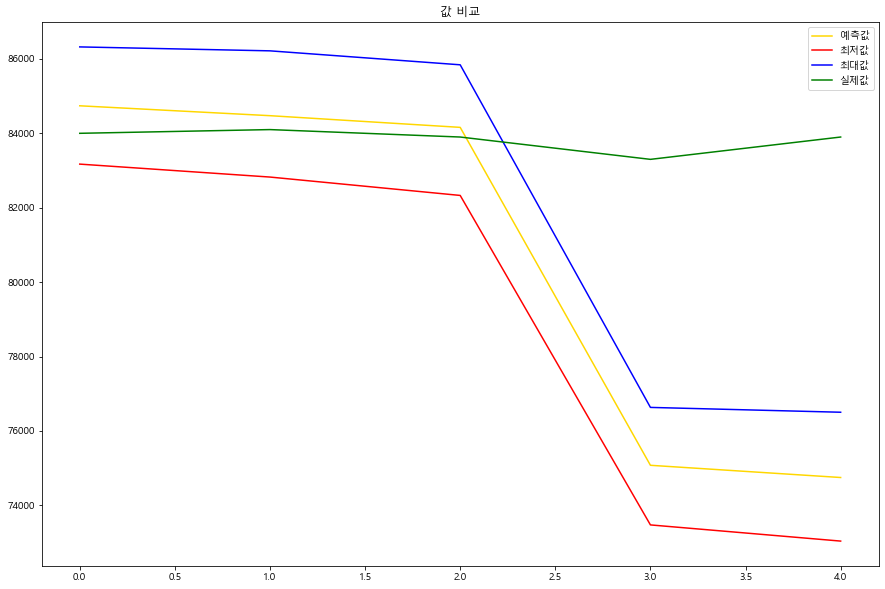

In [18]:
plt.figure(figsize=[15,10])

# 마지막 5일의 예측 데이터 
pred_y = forecast_data.yhat.values[-5:]
# 실제 5일의 데이터
test_y = test.y.values

# 마지막 5일의 예측 데이터 최소값
pred_y_lower = forecast_data.yhat_lower.values[-5:]
# 마지막 5일의 예측 데이터 최대값
pred_y_upper = forecast_data.yhat_upper.values[-5:]

# 모델이 예측한 가격 그래프
plt.plot(pred_y, color = 'gold')

# 모델이 예측한 최저 가격 그래프
plt.plot(pred_y_lower, color = 'red')

# 모델이 예측한 최고 가격 그래프
plt.plot(pred_y_upper, color = 'blue')

# 실제 가격 그래프
plt.plot(test_y, color = 'green')

plt.legend(['예측값', '최저값','최대값','실제값'])
plt.title("값 비교")

### Step3 활용: 더 나은 결과를 위한 방법

- 첫 번째로 고려해볼 방법은 상한값 혹은 하한값을 지정해주는 것이다. 바닥과 천장이 없는 주가 데이터의 경우 의미가 없을 수 있지만 일반적인 시계열 데이터에서는 상한값 혹은 하한값을 설정해 주는 것이 모델의 성능을 높여줄 수 있는 방법중 하나입니다.

데이터셋에 상한선을 설정해서 학습 결과를 시각화해 보겠습니다.

In [19]:
train['cap'] = 90000

# 상한가 적용을 위한 파라미터를 다음과 같이 설정
prophet = Prophet(seasonality_mode = 'multiplicative',
                 growth = 'logistic',
                 yearly_seasonality = True,
                 weekly_seasonality = True, 
                 daily_seasonality = True,
                 changepoint_prior_scale = 0.5)
prophet.fit(train)

In [20]:
# 5일 예측
future_data = prophet.make_future_dataframe(periods = 5, freq= 'd')

future_data['cap']= 90000
forecast_data = prophet.predict(future_data)

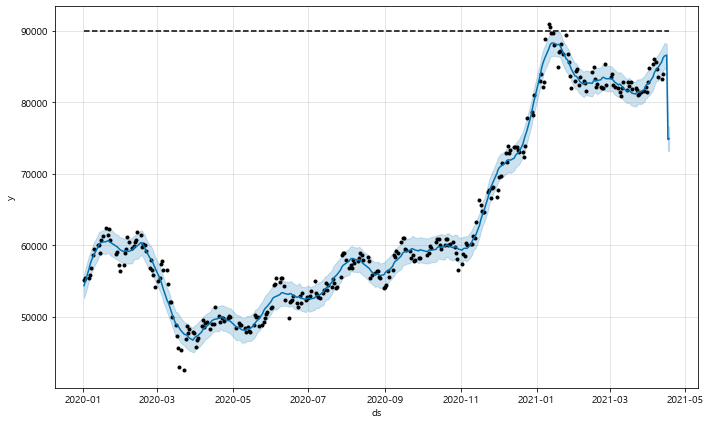

In [21]:
fig = prophet.plot(forecast_data)

이상치 제거 

- 이상치 : 평균적인 수치에 비해 지나치게 높거나 낮은 수치의 데이터를 의미합니다.
- 90000이 넘으면 데이터를 이상치라고 설정해봅니다. 

In [ ]:
df 